In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

import re

In [2]:
DATA_BASEPATH = "./data/data-science-for-good/versions/18"
CENSUS_ZIPFILES = "./data/census_zip_shapefiles"
PROCESSED_CSVS = "./data/processed_csv"
dpt = "11-00091"
DPT_ACS_PATH = os.path.join(DATA_BASEPATH, f"Dept_{dpt}", f"{dpt}_ACS_data")
CENSUS_SHAPE_PATH = os.path.join(DPT_ACS_PATH, "census_shapefiles")

POLICE_SHAPE_FOLDER = os.path.join(DATA_BASEPATH, f"DEPT_{dpt}", f"{dpt}_Shapefiles")

In [3]:
warnings.filterwarnings("ignore")
sns.set_style(style="white")
pd.set_option("display.width", None)
# pd.set_option("display.max_colwidth", None)

In [4]:
# shape files for first department:
for file in os.listdir(POLICE_SHAPE_FOLDER):
    if ".shp" in file:
        shp_file = file

dpt_gdf = gpd.read_file(os.path.join(POLICE_SHAPE_FOLDER, shp_file)).to_crs(epsg="4326")
dpt_gdf.shape

(12, 6)

In [5]:
# load tracts shape file
tracts_gdf = gpd.read_file(
    os.path.join(CENSUS_SHAPE_PATH, "tl_2020_25_tract.shp")
).to_crs(epsg="4326")

tracts_gdf.shape

(1620, 13)

In [6]:
# load census tract dataframe
census_df = pd.read_csv(os.path.join(PROCESSED_CSVS, "02_merged_census_data.csv"))
census_df.rename(columns={"GEO.id2": "GEOID"}, inplace=True)
census_df["GEOID"] = census_df["GEOID"].astype(str)
census_df.shape

(204, 126)

In [7]:
# merge census data with geometry
census_gdf = tracts_gdf.merge(census_df, left_on="GEOID", right_on="GEOID")
census_gdf.shape

(180, 138)

In [8]:
# get intersections with police districts
intersections = gpd.overlay(census_gdf, dpt_gdf, how="intersection")
intersections.shape

(235, 143)

In [9]:
# get weighted average based on area of intersection
# distribute the tracts over the districts:  the violaitons data is given per district, additionaly due to size: the districts are larger.
intersections["area"] = intersections.geometry.area
intersections["census_area_percent_in_district"] = intersections[
    "area"
] / intersections.groupby("GEOID")["area"].transform("sum")

In [10]:
intersections.shape

(235, 145)

The goal here is to unite the census tracts with the districts, to get district based demographics data. 
the demographics are given in absolute estimate numbers, as well as in percentages. 
the 'census_area_percent_in_district' column would be the weight by which the absolute counters would be multiplied.
Next the rows will be aggregated by district, with sum for the 'count' columns, and weighted (by the same weights) average for the percentages, 
to eventually yield the district data. 

In [11]:
# calculate the weighted averaged census data per district:
# only for columns in absulute estimates and not percentages
def classify_columns(df):
    """
    classifies the columns of the census data to percentages or total estimates.
    Args:
        df: pd.DataFrame with census tract columns
    returns:
        list of column names which are total estimates and not percentage columns.
    """
    count_columns = ["ALAND", "AWATER"]  # two columns that
    percent_columns = []
    for col in df.columns:

        # census categories with count estimates only
        if any(
            key in col
            for key in [
                "owner-occupied-housing",
                "income",
                "education-attainment-over-25",
            ]
        ):
            count_columns.append(col)

        # categories with different coding for percentage and counts than the rest
        elif col.endswith("education-attainment"):
            match = re.search(r"HC0(\d+)$", col)
            if match and int(match.group(1)) % 2 == 0:  # even code
                percent_columns.append(col)
            else:
                count_columns.append(col)

        elif col.endswith("employment"):
            match = re.search(r"HC0(\d+)$", col)
            if match and int(match.group(1)) == 1:  # ends with 1
                count_columns.append(col)  # only HC01 is total, the rest is ratios
            else:
                percent_columns.append(col)

        # for other categories, HC03 is the percentages
        elif "HC03" in col:
            percent_columns.append(col)

        # the remaining census data columns are counts
        elif col.startswith("HC"):
            count_columns.append(col)

        else:
            continue

    return count_columns, percent_columns

In [12]:
# multiply the count features by the weights:
count_cols, percent_cols = classify_columns(intersections)
intersections[count_cols] = intersections[count_cols].mul(
    intersections["census_area_percent_in_district"], axis=0
)
remaining_cols = [
    x for x in intersections.columns if x not in percent_cols + count_cols
]
len(remaining_cols)

20

In [13]:
intersections[["DISTRICT", "DISTRICT_I"]]

,DISTRICT,DISTRICT_I
0,E18,0.0
1,E18,0.0
2,E18,0.0
3,E5,0.0
4,B3,0.0
...,...,...
230,E18,0.0
231,E5,0.0
232,E5,0.0
233,E18,0.0


In [14]:
# define a weighted average function for the ratio columns
def weighted_mean(series, weights):
    """
    Compute weighted mean for a pandas series.
    Args:
        series: pd.Series - the column that needs to be converted
        weights: pd.Series - the column that holds the weights by which the series is multiplied.
    """
    return (series * weights).sum() / weights.sum()

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER',
       ...
       'HC03_VC91_race-sex-age', 'HC01_VC99_race-sex-age', 'DISTRICT_I', 'ID',
       'DISTRICT', 'SHAPE_area', 'SHAPE_len', 'geometry', 'area',
       'census_area_percent_in_district'],
      dtype='object', length=145)

In [41]:
def aggregate_districts(df, count_cols, percent_cols):
    """
    Aggregate census tract demographic features by police districts using weights.

    Args:
        df: GeoDataFrame with the districts, relevant area-based weights and demographic features
        count_cols: list of columns to sum
        percent_cols: list of percentage columns to weighted-average

    Returns:
        DataFrame aggregated by district_id
    """
    results = []
    for district, group in intersections.groupby("DISTRICT"):
        row = {"DISTRICT": district}

        # counts: weighted sum is same as sum after scaling
        for col in count_cols:
            row[col] = group[col].sum()

        # percentages: weighted mean
        for col in percent_cols:
            row[col] = weighted_mean(
                group[col], group["census_area_percent_in_district"]
            )

        results.append(row)

    return pd.DataFrame(results, columns=df.columns).set_index("DISTRICT").reset_index()

In [43]:
grouped_df = aggregate_districts(intersections, count_cols, percent_cols)

grouped_df = grouped_df.drop(columns=remaining_cols)
grouped_df

,DISTRICT,ALAND,AWATER,HC01_EST_VC03_education-attainment,HC04_EST_VC04_education-attainment,HC06_EST_VC04_education-attainment,HC02_EST_VC05_education-attainment,HC01_EST_VC06_education-attainment,HC04_EST_VC13_education-attainment,HC04_EST_VC25_education-attainment,...,HC03_VC16_race-sex-age,HC03_VC38_race-sex-age,HC01_VC45_race-sex-age,HC01_VC62_race-sex-age,HC01_VC63_race-sex-age,HC01_VC73_race-sex-age,HC01_VC80_race-sex-age,HC03_VC89_race-sex-age,HC03_VC91_race-sex-age,HC01_VC99_race-sex-age
0,A1,1.599755e+06,4.750528e+05,26.274129,77.769349,99.889554,245.972069,1755.818682,14.917381,892.690709,...,3.302136,45.977091,374.500314,21.753127,117.404964,204.606584,20.000000,0.306449,0.120244,63.407515
1,A15,3.505616e+06,1.257495e+06,92.991486,244.461301,103.256889,144.379567,316.985294,15.497368,547.835604,...,5.149826,36.468223,398.993808,77.992260,71.951239,85.993808,33.000000,0.450058,0.033338,84.000000
2,A7,1.707322e+07,9.751764e+06,1123.883919,563.138411,462.169543,500.214093,601.000000,57.124849,1158.333512,...,5.317697,42.359107,11311.784168,541.000000,414.000000,171.000000,615.403266,3.101878,0.103151,141.767838
3,B2,1.052379e+07,5.430765e+04,1402.994995,572.125206,468.228272,944.610564,1977.327293,99.078047,1697.134984,...,5.274497,40.556289,2517.334717,299.424192,462.084107,166.603549,663.208062,0.698020,0.315041,1665.240491
4,B3,8.622290e+06,4.112491e+04,1143.283792,404.382885,298.021153,493.328218,402.982415,62.000828,947.039223,...,6.057480,42.968054,1274.753086,879.140333,116.873656,22.723871,662.270282,0.287244,0.203836,315.210196
5,C11,1.315792e+07,3.896292e+06,935.818888,486.955829,415.933701,745.761880,1145.219031,75.912533,1412.017289,...,6.265467,39.530248,2724.369659,8972.443702,247.275945,388.330904,670.300370,0.586173,0.153746,3616.735494
6,C6,7.518406e+06,2.616340e+06,469.932391,257.114528,144.537033,355.285077,1820.195003,38.329607,1184.034236,...,4.628864,40.019364,820.284669,706.422025,200.848293,161.659955,376.581905,0.508615,0.298691,270.032083
7,D14,6.243091e+06,1.066533e+06,167.000000,160.557688,107.609094,612.502516,4095.089903,40.039405,1171.312520,...,3.274602,43.094891,1091.147795,111.038141,578.017027,339.053124,390.022476,1.395624,0.310269,441.003405
8,D4,5.201708e+06,4.794875e+05,335.024689,382.997193,326.595503,1034.815855,2676.589042,65.629771,1862.392785,...,4.137928,46.858354,2045.096403,360.813146,1011.945783,598.808975,435.124074,1.518841,0.678011,412.892015
9,E13,9.114464e+06,2.471327e+05,319.933948,258.687970,140.582375,535.741263,939.241955,36.826932,1180.406357,...,5.826691,40.442787,1257.031911,65.299133,254.561237,403.902880,243.290717,0.717873,1.041329,264.385570


In [44]:
grouped_gdf = grouped_df.merge(
            intersections[["DISTRICT", "geometry"]],
            on="DISTRICT",
            how="left"
        )
grouped_gdf = gpd.GeoDataFrame(grouped_gdf, geometry="geometry", crs=dpt_gdf.crs)


In [ ]:
grouped_df.to_csv(
    os.path.join(PROCESSED_CSVS, "03_tract_data_by_district.csv"), index=False
)

## Merge with police file

In [20]:
cat_df = pd.read_csv(
    "./data/processed_csv/01_clean_df11.csv",
    converters={"month_year": lambda x: pd.Period(x, freq="M")},
)
cat_df.head()

,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_DISTRICT,INCIDENT_DATE,SUBJECT_PRIORS,SUBJECT_RACE,SUBJECT_COMPLEXTION,FIOFS_TYPE,TERRORISM,VIOLATION_REASON,...,OFFICER_ID,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE,MONTH,YEAR,WEEKDAY,month_year,OFFICER_AGE_GROUP,GROUPED_VIOLATION_REASON
0,621880,MALE,B2,2013-12-10,YES,B(Black),Med,IOFS,NO,"DRUGS, INVESTIGATION",...,98656.0,B2,B(Black),59,12,2013,1,2013-12,51-60,"INVESTIGATE, OTHER"
1,565177,MALE,A1,2012-05-24,NO,W(White),Med,IO,NO,"DRUGS, POSSESSION",...,9765.0,A1,W(White),26,5,2012,3,2012-05,18-30,"ALCOHOL, DRUGS"
2,565340,MALE,C11,2012-06-04,YES,B(Black),Dark,IOF,NO,"INVESTIGATE, PERSON",...,83575.0,YVSF,B(Black),18,6,2012,0,2012-06,18-30,"INVESTIGATE, PERSON"
3,653895,MALE,B2,2014-06-21,YES,B(Black),Med,IOFS,NO,ABDW,...,76146.0,BIKE,B(Black),24,6,2014,5,2014-06,18-30,ASSULT_VIOLENCE
4,566043,MALE,B2,2010-12-02,YES,B(Black),Light,IO,NO,VAL,...,107106.0,B2,B(Black),70,12,2010,3,2010-12,61-70,"ALCOHOL, DRUGS"


In [45]:
# merge census columns on districts:
merged_dpt_census = pd.merge(
    cat_df, grouped_gdf, left_on="LOCATION_DISTRICT", right_on="DISTRICT", how="left"
)
merged_dpt_census = merged_dpt_census.drop(columns='DISTRICT')
merged_dpt_census.shape

(3318365, 148)

### Save to CSV

In [25]:
merged_dpt_census.to_csv("./data/processed_csv/04_combined_dpt_tract.csv", index=False)

## Visualizations

In [47]:
gdf = aggregated = gpd.GeoDataFrame(merged_dpt_census, geometry="geometry", crs=dpt_gdf.crs)


In [ ]:
incidents_per_district = (
    gdf.groupby("LOCATION_DISTRICT")
    .size()
    .reset_index(name="incident_count")
)

# merge back into grouped_gdf (geometry + poverty info)
plot_gdf = grouped_gdf.merge(
    incidents_per_district, left_on="DISTRICT", right_on="LOCATION_DISTRICT", how="left"
)



In [57]:
plot_gdf['HC01_EST_VC01_employment']

0      2122.388478
1      2122.388478
2      2122.388478
3      2122.388478
4      2122.388478
          ...     
230    3297.459081
231    3297.459081
232    3297.459081
233    3297.459081
234    3297.459081
Name: HC01_EST_VC01_employment, Length: 235, dtype: float64

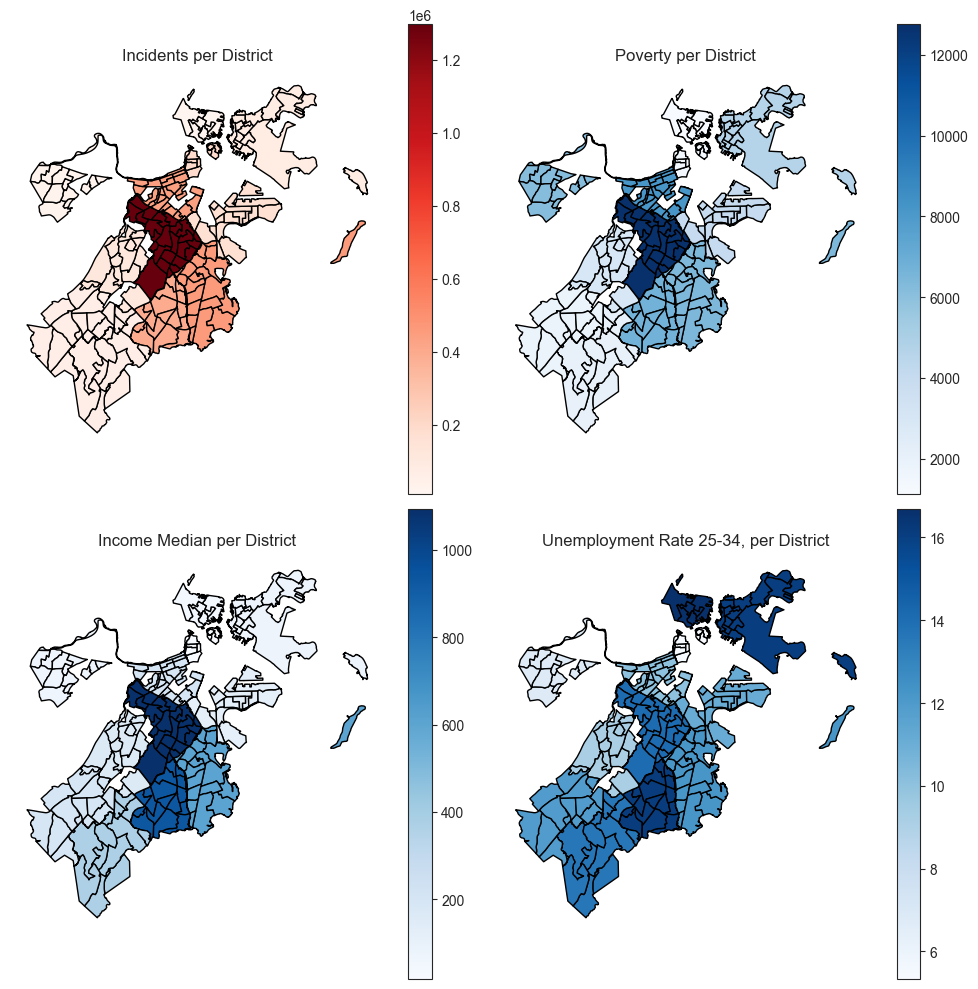

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plot_gdf.plot(
    column="incident_count",
    cmap="Reds",
    legend=True,
    ax=axes[0,0],
    edgecolor="black"
)
axes[0,0].set_title("Incidents per District")
axes[0,0].axis("off")

plot_gdf.plot(
    column="HC01_EST_VC52_poverty",   
    cmap="Blues",
    legend=True,
    ax=axes[0,1],
    edgecolor="black"
)
axes[0,1].set_title("Poverty per District")
axes[0,1].axis("off")

plot_gdf.plot(
    column="HC01_EST_VC05_income",   
    cmap="Blues",
    legend=True,
    ax=axes[1,0],
    edgecolor="black"
)
axes[1,0].set_title("Income Median per District")
axes[1,0].axis("off")

plot_gdf.plot(
    column="HC04_EST_VC04_employment",   
    cmap="Blues",
    legend=True,
    ax=axes[1,1],
    edgecolor="black"
)

axes[1,1].set_title("Unemployment Rate 25-34, per District")
axes[1,1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
cols_with_income = [col for col in plot_gdf.columns if "poverty" in col]
print(cols_with_income)

['HC01_EST_VC05_income', 'HC02_EST_VC05_income', 'HC01_EST_VC07_income', 'HC02_EST_VC07_income', 'HC02_EST_VC12_income', 'HC02_EST_VC13_income', 'HC02_EST_VC16_income', 'HC01_EST_VC17_income', 'HC02_EST_VC17_income', 'HC02_EST_VC19_income', 'HC01_EST_VC27_income', 'HC01_EST_VC31_income', 'HC01_EST_VC41_income']


In [29]:
# plot poverty per district vs. number of incidents per district
# incidents per district

map_df = merged_dpt_census.copy()
incident_per_district = (
    map_df.groupby("LOCATION_DISTRICT").size().reset_index(name="incident_count")
)

incident_per_district



,LOCATION_DISTRICT,incident_count
0,A1,14812
1,A15,1761
2,A7,4939
3,B2,37060
4,B3,21817
5,C11,18491
6,C6,8353
7,D14,2049
8,D4,15686
9,E13,5847


In [ ]:
# Plot districts on map by Incident number
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

map_gdf.plot(
    column="incident_count",
    cmap="OrRd",
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
    legend=True,
)

# Add district labels to the map
map_gdf.apply(
    lambda x: ax.annotate(
        text=x["DISTRICT"], xy=x.geometry.centroid.coords[0], ha="center", fontsize=10
    ),
    axis=1,
)

ax.set_title("Number of Police Incidents per District", fontsize=16)
ax.set_axis_off()  # Hide the axes
plt.show()

In [ ]:
gdf = grouped_gdf.copy()

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle("Population Concentrations by Race")


pop_cols = {
    "HC03_VC49": "White Population (%)",
    "HC03_VC50": "Black Population (%)",
    "HC03_VC56": "Asian Population (%)",
    "HC03_VC88": "Hispanic Population (%)",
}

cmaps = ["Blues", "Greens", "Oranges", "Purples"]

for ax, (col, title), cmap in zip(axs.flatten(), pop_cols.items(), cmaps):
    gdf.plot(
        column=col,
        ax=ax,
        cmap=cmap,
        legend=True,
        edgecolor="white",
        linewidth=0.3,
        missing_kwds={"color": "lightgrey", "label": "Missing values"},
    )
    ax.set_title(title, fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()